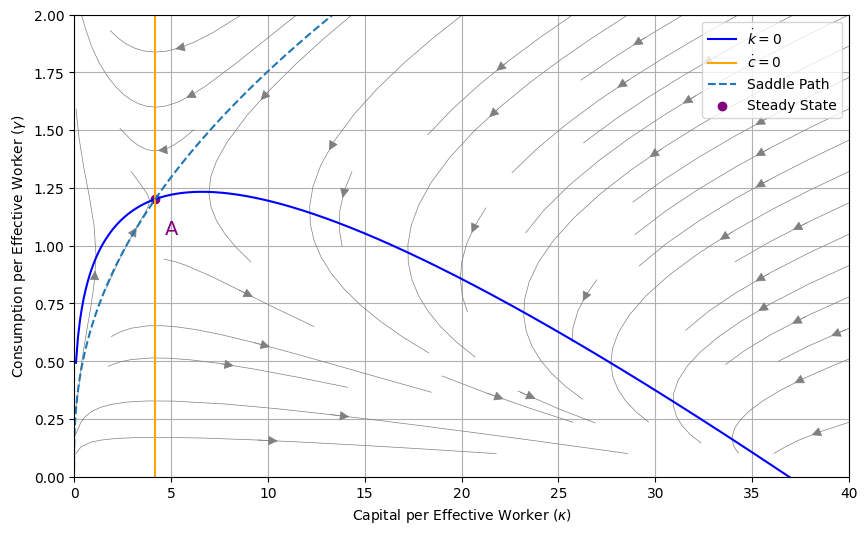

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import interpolate
from numpy import linalg as LA

# Parameters
alpha = 0.3  # Output elasticity of capital
rho = 0.02   # Time preference rate
n = 0.01     # Population growth rate
g = 0.02     # Technological progress rate
delta = 0.05 # Depreciation rate
theta = 2    # Intertemporal elasticity of substitution

npoints = 400
k_min = 0.1
k_max = 40
c_min = 0.1
c_max = 2;
# Cobb-Douglas production function
def f(k):
    return k**alpha

# Marginal product of capital
def mpk(k):
    return alpha * k**(alpha - 1)

def dcdt(c,k):
    """
    Consumption differential equation
    """
    dc = c/theta*(mpk(k) - delta - rho -theta*g)
    return(dc)

def dkdt(c,k):
    """
    Capital differential equation
    """
    dk = f(k) - c - (n+g+delta)*k
    return(dk)

def dcdk(c,k):
    """
    Differential equation for the time elimination method.
    This corresponds to dc/dk = (dc/dt)/(dk/dt)
    """
    return(dcdt(c,k)/dkdt(c,k))

# Phase diagram
k_vals = np.linspace(k_min, k_max, npoints)  # Capital per worker
c_vals = np.linspace(c_min, c_max, npoints)  # Consumption per worker
K, C = np.meshgrid(k_vals, c_vals)

# Dynamics
k_dot = f(K) - C - (n + delta + g) * K  # Change in capital per worker
c_dot = C * (mpk(K) - rho - delta - theta*g) / theta  # Change in consumption per worker

# Zero isoclines
kdot_zero = f(k_vals) - (n + delta + g) * k_vals

# Steady-state values
k_star = ((rho + delta + theta*g) / alpha) ** (1 / (alpha - 1))
c_star = f(k_star) - (n + delta + g) * k_star

# # Compute saddle path
# def saddle_path(k_vals, k_star, c_star):
#    """Numerical approximation of the saddle path."""
#    saddle_c = []
#    for k in k_vals:
#        c = c_star * (k / k_star) ** (1 / theta)
#        saddle_c.append(c)
#    return saddle_c

# saddle_c_analytical = saddle_path(k_vals, k_star, c_star)

#k_dot = f(K) - C - (n + delta + g) * K  # Change in capital per worker
#c_dot = C * (mpk(K) - rho - delta - theta*g) / theta  # Change in consumption per worker

# Saddle path approximation near the steady state
def saddle_path_linear(k_star, c_star):
        # Jacobian matrix at the steady state
        A = np.array([
        [mpk(k_star) - (n + delta + g), -1],
        [c_star * alpha*(alpha - 1) * k_star**(alpha - 2), (mpk(k_star) - rho - delta - theta*g)/theta]])
        # Eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eig(A)
        # Select the stable eigenvector (associated with the negative eigenvalue)
        stable_eigenvalue = eigenvalues[np.argmin(eigenvalues)]
        stable_eigenvector = eigenvectors[:, np.argmin(eigenvalues)]
        slope_saddle_path = stable_eigenvector[1] / stable_eigenvector[0]
        return c_star + slope_saddle_path * (k_vals - k_star)

def J_matrix(k_star,c_star):
    """
    Returns the matrix of first derivatives of the solution's dynamic system
    evaluated at the point (c,k).
    This matrix is used for linear approximations of the system around point
    (c,k).
    """
    J = np.array([
        [mpk(k_star) - (n + delta + g), -1],
        [c_star * alpha*(alpha - 1) * k_star**(alpha - 2), (mpk(k_star) - rho - delta - theta*g)/theta]])

    return(J)

def slope_ss():
    """
    Finds the slope of the saddle path at the steady state.
    """
    J = J_matrix(c_star,k_star)

    # Find eigenvalues and eigenvectors
    w, v = LA.eig(J)
    # Find position of smallest eigenvalue
    min_eig = np.argsort(w)[0]

    # The slope of the saddle path is that
    # generated by the eigenvector of the
    # negative eigenvalue.
    slope = v[0,min_eig]/v[1,min_eig]

    return(slope)


# def saddle_path_nonlinear(eps = 10**(-8), npoints = 200):
#     """
#     Solves for the model's consumption rule through the time elimination
#     method.

#     Parameters:
#     - eps:     disturbance used to prevent dc/dk from becoming 0/0 at
#                 the steady state value of capital.
#     - npoints: number of points used on each side of the steady
#                 state capital for solving the dc/dk equation.
#     """
#     # K ranges, avoiding kss through a small disturbance
#     k_below = np.linspace(k_star-eps,k_min,npoints)
#     k_above = np.linspace(k_star+eps,k_max,npoints)
#     k = np.concatenate((k_below,k_above)).flatten()

#     # Solve for c on each side of the steady state capital,
#     # Using the slope of the saddle path to approximate initial
#     # conditions
#     c_below = odeint(dcdk,c_star - eps*slope_ss(), k_below)
#     c_above = odeint(dcdk,c_star + eps*slope_ss(), k_above)

#     c = np.concatenate((c_below,c_above)).flatten()

#     # Create consumption function as an interpolation of the
#     # numerical solutions.
#     saddle_path = interpolate.interp1d(k,c)
#     return(saddle_path)

def saddle_path(k_star, c_star, k_max, eps=10**(-6), npoints=400):
    # Capital grid around steady state
    k_below = np.linspace(k_star - eps, 0.0001, npoints)
    k_above = np.linspace(k_star + eps, k_max, npoints)
    k = np.concatenate((k_below, k_above)).flatten()

    # Initial consumption conditions based on slope
    c_below = odeint(dcdk, c_star - eps * slope_ss(), k_below)
    c_above = odeint(dcdk, c_star + eps * slope_ss(), k_above)
    c = np.concatenate((c_below, c_above)).flatten()

    # Sort the results to match the order of k values
    sorted_indices = np.argsort(k)
    k_saddle = k[sorted_indices]
    c_saddle = c[sorted_indices]

    return k_saddle, c_saddle
    # Create consumption function as an interpolation of the
    # numerical solutions.

k_saddle_path,c_saddle_path=saddle_path(k_star, c_star, k_max, eps=10**(-6), npoints=400)
# def saddle_path():

# Plotting
plt.figure(figsize=(10, 6))

# Stream plot for dynamics
plt.streamplot(K, C, k_dot, c_dot, color='gray', density=0.5, linewidth=0.5, arrowsize=1.5)

# Zero isoclines
plt.plot(k_vals, kdot_zero, label=r'$\dot{k} = 0$', color='blue', linestyle='-')
plt.axvline(k_star, color='orange', linestyle='-', label=r'$\dot{c} = 0$')

# Saddle path
plt.plot(k_saddle_path,c_saddle_path, '--', label="Saddle Path")
# Plot saddle path
# Steady state
plt.scatter(k_star, c_star, color='purple', label='Steady State')

# Labels and title
plt.xlabel('Capital per Effective Worker ($\\kappa$)')
plt.ylabel('Consumption per Effective Worker ($\\gamma$)')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.text(k_star+0.5, c_star-0.15, "A", fontsize=14, color='purple')
plt.legend(loc="best")
plt.grid(True)
plt.xlim(0, 40)
plt.ylim(0, 2)
plt.savefig("phase_diagram.png", dpi=300, bbox_inches='tight')
plt.show()